In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
from keras import optimizers
import keras_metrics as km # for precsion/ recall metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint # to save best model
from keras.models import load_model

from sklearn.model_selection import train_test_split

import glob
import json
import matplotlib.pyplot as plt

# for openvino
import tensorflow as tf

Using TensorFlow backend.
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/ana

In [2]:
#%%
from data_generator_sx3 import SX3Dataset
from data_generator import CorrDatasetV2
from model import Model
from utils import save_model#, load_model

### Load data

In [3]:
#%% prepare sx3 data (only module)
dataset_mp = SX3Dataset(label=1, global_path='sx3_data/outputs/mp')
dataset_nomp = SX3Dataset(label=0, global_path='sx3_data/outputs/no_mp')

data_mp = dataset_mp.build()
data_nomp = dataset_nomp.build()[:500]

dataset = np.concatenate((data_mp, data_nomp), axis=0)
np.random.shuffle(dataset)

data_train, data_val = train_test_split(dataset, test_size=0.2)

# 1 channel image (only module), add newaxis
X_train_sx = np.array([x['table'] for x in data_train])
X_val_sx = np.array([x['table'] for x in data_val])

y_train_sx = np.array([x['label'] for x in data_train])
y_val_sx = np.array([x['label'] for x in data_val])

In [4]:
# check shapes
X_train_sx.shape, X_val_sx.shape

((176, 40, 40, 2), (44, 40, 40, 2))

In [6]:
#%% prepare data generator data (only module)
global_path_mp_i = 'synth_data/mp/*_i_*'
global_path_mp_q = 'synth_data/mp/*_q_*'
global_path_nomp_i = 'synth_data/no_mp/*_i_*'
global_path_nomp_q = 'synth_data/no_mp/*_q_*'
paths_mp_i = sorted(glob.glob(global_path_mp_i))
paths_mp_q = sorted(glob.glob(global_path_mp_q))
paths_nomp_i = sorted(glob.glob(global_path_nomp_i))
paths_nomp_q = sorted(glob.glob(global_path_nomp_q))

synth_data_samples = []
synth_data_labels = []
for path_mp_i, path_mp_q in zip(paths_mp_i, paths_mp_q):
    matr_i = pd.read_csv(path_mp_i, sep=',', header=None).values
    matr_q = pd.read_csv(path_mp_q, sep=',', header=None).values
    matr_i = matr_i[...,None]
    matr_q = matr_q[...,None]
    matr = np.concatenate((matr_i, matr_q), axis=2)
    #matr = matr_i**2 + matr_q**2
    synth_data_samples.append(matr)
    synth_data_labels.append(1)
    
for path_nomp_i, path_nomp_q in zip(paths_nomp_i, paths_nomp_q):
    matr_i = pd.read_csv(path_nomp_i, sep=',', header=None).values
    matr_q = pd.read_csv(path_nomp_q, sep=',', header=None).values
    matr_i = matr_i[...,None]
    matr_q = matr_q[...,None]
    matr = np.concatenate((matr_i, matr_q), axis=2)
    #matr = matr_i**2 + matr_q**2
    synth_data_samples.append(matr)
    synth_data_labels.append(0)

synth_data_samples = np.array(synth_data_samples)
synth_data_labels = np.array(synth_data_labels)

X_train_synth, X_val_synth, y_train_synth, y_val_synth = train_test_split(synth_data_samples, synth_data_labels, test_size=0.2, shuffle=True)


### Build, train, save model

In [31]:
batch_size = 8
train_iters = 20
learning_rate = 1e-4

In [35]:
#%% Define model.
if X_train_sx.shape[1] in [20, 40, 60, 80]:
    model = Model(shape=(X_train_sx.shape[1], X_train_sx.shape[2], X_train_sx.shape[3]))
elif X_train_sx.shape[1] == 10:
    model = Model10(shape=(X_train_sx.shape[1], X_train_sx.shape[2], X_train_sx.shape[3]))
elif X_train_sx.shape[1] == 8:
    model = Model8(shape=(X_train_sx.shape[1], X_train_sx.shape[2], X_train_sx.shape[3]))
elif X_train_sx.shape[1] == 4:
    model = Model4(shape=(X_train_sx.shape[1], X_train_sx.shape[2], X_train_sx.shape[3]))
    
model.model.compile(loss='binary_crossentropy',
					optimizer=optimizers.Adam(lr=learning_rate),
					metrics=['acc',
						   km.binary_precision(),
						   km.binary_recall()])

tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn


In [55]:
model.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 38, 16)        304       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)             

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [36]:
# load model from .h5
#model.model = load_model('saved_models/sc1_data_gen_train.pkl')
#model.model = load_model('saved_models/sc2_fine_tune.pkl')

In [37]:
# train model, sae best weigths with checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/best_model/best_mp_model.h5', verbose=1, save_best_only=True)

#%% Train model: pretrain on data gen
history = model.model.fit(
    x=X_train_sx,
    y=y_train_sx,
    validation_data=(X_val_sx, y_val_sx),
    epochs=train_iters,
    batch_size=batch_size,
    callbacks=[checkpointer]
    )
#save_model(model.model, 'saved_models/sc1_data_gen_train_zoom.pkl')


[ WARNING ] From /home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 3s 33ms/step - loss: 0.7006 - acc: 0.4875 - precision: 0.6325 - recall: 0.7441 - val_loss: 0.7069 - val_acc: 0.4000 - val_precision: 0.4875 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.70691, saving model to saved_models/best_model/best_mp_model.h5
Epoch 2/20
80/80 [==============================] - 1s 8ms/step - loss: 0.6869 - acc: 0.5375 - precision: 0.5148 - recall: 1.0000 - val_loss: 0.7004 - val_acc: 0.4000 - val_precision: 0.4875 - val_recall: 1.0000

Epoch 00002: val_loss improved from 0.70691 to 0.70042, saving model to saved_models/best_model/best_mp_model.h5
Epoch 3/20
80/80 [==============================] - 1s 8ms/step - loss: 0.6807 - acc: 0.6

### Convert Keras model .h5 to TF frozen graph .pb

In [42]:
# keras to tf conversion

keras_model_path = 'saved_models/best_model/best_mp_model.h5'

# freeze state of a session into a pruned compilation graph
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = convert_variables_to_constants(session, input_graph_def, 
                                                      output_names, freeze_var_names)
        return frozen_graph
    
# loading keras model
K.set_learning_phase(0)
model = load_model(keras_model_path,
                  custom_objects={
                      'binary_precision': km.binary_precision(),
                      'binary_recall': km.binary_recall()
                  })

# create frozen graph of the keras model
frozen_graph = freeze_session(K.get_session(), 
                              output_names=[out.op.name for out in model.outputs])

# save model as .pb file
tf.train.write_graph(frozen_graph, 'saved_models/tf_model', 'tf_mp_model.pb', as_text=False)

tracking <tf.Variable 'Variable_8:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_9:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_10:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_11:0' shape=() dtype=int32> fn
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
[ WARNING ] From <ipython-input-42-83715c089b2f>:18: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
[ WARNING ] From /home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_u

'saved_models/tf_model/tf_mp_model.pb'

### Convert TF .pb to IR model

In [43]:
# convert tensorflow graph to ir_model (from terminal or bash)
! chmod 744 convert_tf_ncs2.sh
! ./convert_tf_ncs2.sh

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/tf_model/tf_mp_model.pb
	- Path for generated IR: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/ir_model
	- IR output name: 	ir_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,40,40,2]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- 

### Make inference on NCS2

In [7]:
# check dimensions/ indices
#print(X_train_sx[0].shape)
#prepimg = np.ndarray(shape=(n,c,h,w))
#prepimg[0, 0, :,:] = np.moveaxis(X_train_sx[0], -1, 0)[0,:]
#print(prepimg.shape)

#np.moveaxis(X_train_sx[0], -1, 0)[0,:].shape
#ind = np.random.choice(range(X_train_sx.shape[0]))
#ind

(40, 40)

In [63]:
# plugin initialization for specified device
plugin = IEPlugin(device='MYRIAD')

# read ir model
log.info('loading network files: \n\t{}\n\t{}'.format(model_xml_path, model_bin_path))
net = IENetwork(model=model_xml_path, weights=model_bin_path)
net.inputs, net.outputs 

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model.xml
	saved_models/ir_model/ir_model.bin


({'conv2d_5_input_1': <openvino.inference_engine.ie_api.InputInfo at 0x7f712d4e2ab0>},
 {'dense_4_1/Sigmoid': <openvino.inference_engine.ie_api.OutputInfo at 0x7f712d4e2c30>})

In [58]:
# run inference on NCS2
import cv2
import sys
import os
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

log.basicConfig(format='[ %(levelname)s ] %(message)s', level=log.INFO, stream=sys.stdout)
model_xml_path = 'saved_models/ir_model/ir_model.xml' # model
model_bin_path = 'saved_models/ir_model/ir_model.bin' # weights

# plugin initialization for specified device
plugin = IEPlugin(device='MYRIAD')

# read ir model
log.info('loading network files: \n\t{}\n\t{}'.format(model_xml_path, model_bin_path))
net = IENetwork(model=model_xml_path, weights=model_bin_path)

log.info('Preparing input blobs')
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))

# prepare image
# get shapes
n, c, h, w = net.inputs[input_blob].shape
log.info('required img shape:  {},{},{},{}'.format(n, c, h, w))
prepimg = np.ndarray(shape=(n, c, h, w))

# change data layout from HW to NCHW
ind = np.random.choice(range(X_train_sx.shape[0]))
prepimg[0,0,:,:] = np.moveaxis(X_train_sx[ind], -1, 0)[0,:]
log.info('prepimg shape:  {},{},{},{}'.format(prepimg.shape[0], prepimg.shape[1], prepimg.shape[2], prepimg.shape[3]))

# loading model to plugin
log.info('Loading model to the plugin')
exec_net = plugin.load(network=net)
del net

# start sync inference
log.info('Starting inference ({} iterations)'.format(1))
infer_time = []
t0 = time()
res = exec_net.infer(inputs={input_blob: prepimg})

infer_time.append((time() - t0) * 1000)
log.info('Average running time of one iteration: {} ms'.format(np.average(np.asarray(infer_time))))

# processing output blob
log.info('Processing output blob')
pred_probas = res[out_blob]
# convert probas into labels
preds = (pred_probas > 0.5).astype(int)
#print(ind, pred_probas, preds, y_train_sx[ind])
print('compare pred: ', ind, pred_probas, preds, y_train_sx[ind])

# del plugin to make inference next time
del exec_net
del plugin

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model.xml
	saved_models/ir_model/ir_model.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.914854049682617 ms
[ INFO ] Processing output blob
compare pred:  28 [[1.]] [[1]] 1


In [54]:
input_blob, out_blob

('conv2d_5_input_1', 'dense_4_1/Sigmoid')

In [45]:
X_val_synth.shape, X_val_sx.shape, y_train_sx

((1, 80, 80, 2),
 (20, 40, 40, 2),
 array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]))

(1, 2, 40, 40) (40, 40)


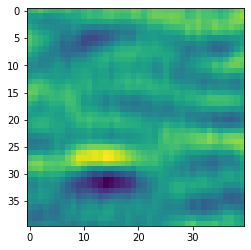

In [12]:
print(prepimg.shape, np.moveaxis(X_val_sx[ind], -1, 0)[0,:].shape)
plt.imshow(prepimg[0,0,:,:])

In [21]:
# del plugin to make inference next time
del exec_net
del plugin